In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df_DA=pd.read_csv("gsearch_jobs.csv",index_col=0)

# Data Cleaning

In [4]:
df_DA.drop(columns=['index','commute_time','salary','extensions','posted_at'],axis=1,inplace=True)
df_DA.sort_values(by='date_time',inplace=True)
df_DA['date_time']=pd.to_datetime(df_DA['date_time'])
df_DA['description_tokens']=df_DA['description_tokens'].apply(lambda skills : ast.literal_eval(skills) if pd.notna(skills) else skills )
df_DA.reset_index(drop=True, inplace=True)

In [5]:
df_DA = df_DA.rename(columns={'title' : 'job_title',
                      'description' : 'job_description',
                      'search_term' : 'job_Title_short',
                      'search_location' : 'country',
                      'description_tokens' : 'job_skills'
                      })

# Skills Trend

In [ ]:
# Add month no column to df
df_DA['date_time_month_no']=df_DA['date_time'].dt.month

In [7]:
df_DA_2023 = df_DA[df_DA['date_time'].dt.year == 2023]
df_DA_2024 = df_DA[df_DA['date_time'].dt.year == 2024]

In [ ]:
# Explode job_skills so that each skill appears in a separate row (one-to-many)
df_DA_2023_exploded = df_DA_2023.explode('job_skills')
df_DA_2024_exploded = df_DA_2024.explode('job_skills')

In [ ]:
# Create pivot table of skill frequencies, using month number as index and filling NaN with 0
df_DA_2023_pivot = df_DA_2023_exploded.pivot_table(index='date_time_month_no',columns='job_skills',aggfunc='size',fill_value=0)
df_DA_2024_pivot = df_DA_2024_exploded.pivot_table(index='date_time_month_no',columns='job_skills',aggfunc='size',fill_value=0)

In [ ]:
# Add a total row for each column, use it to sort skills in descending order, then drop the total row
df_DA_2023_pivot.loc['Total'] = df_DA_2023_pivot.sum()
df_DA_2023_pivot = df_DA_2023_pivot[df_DA_2023_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_2023_pivot = df_DA_2023_pivot.drop('Total',axis=0)

df_DA_2024_pivot.loc['Total'] = df_DA_2024_pivot.sum()
df_DA_2024_pivot = df_DA_2024_pivot[df_DA_2024_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_2024_pivot = df_DA_2024_pivot.drop('Total',axis=0)



In [ ]:
def prepare_pivot(df_pivot):
    """
    Convert month number to month name, 
    drop the original month number column, 
    and set month name as index.
    """
    df_pivot = df_pivot.reset_index()
    df_pivot['date_time_month'] = df_pivot['date_time_month_no'].apply(
        lambda x : pd.to_datetime(x , format = '%m').strftime('%b'))
    df_pivot = df_pivot.drop('date_time_month_no', axis = 1)
    df_pivot.set_index('date_time_month', inplace = True)
    return df_pivot

In [ ]:
# Using function
df_DA_2023_pivot = prepare_pivot(df_DA_2023_pivot)
df_DA_2024_pivot = prepare_pivot(df_DA_2024_pivot)

In [ ]:
# Select the top 5 skills
df_DA_2023_top_skills = df_DA_2023_pivot[df_DA_2023_pivot.columns[:5]]
df_DA_2024_top_skills = df_DA_2024_pivot[df_DA_2024_pivot.columns[:5]]

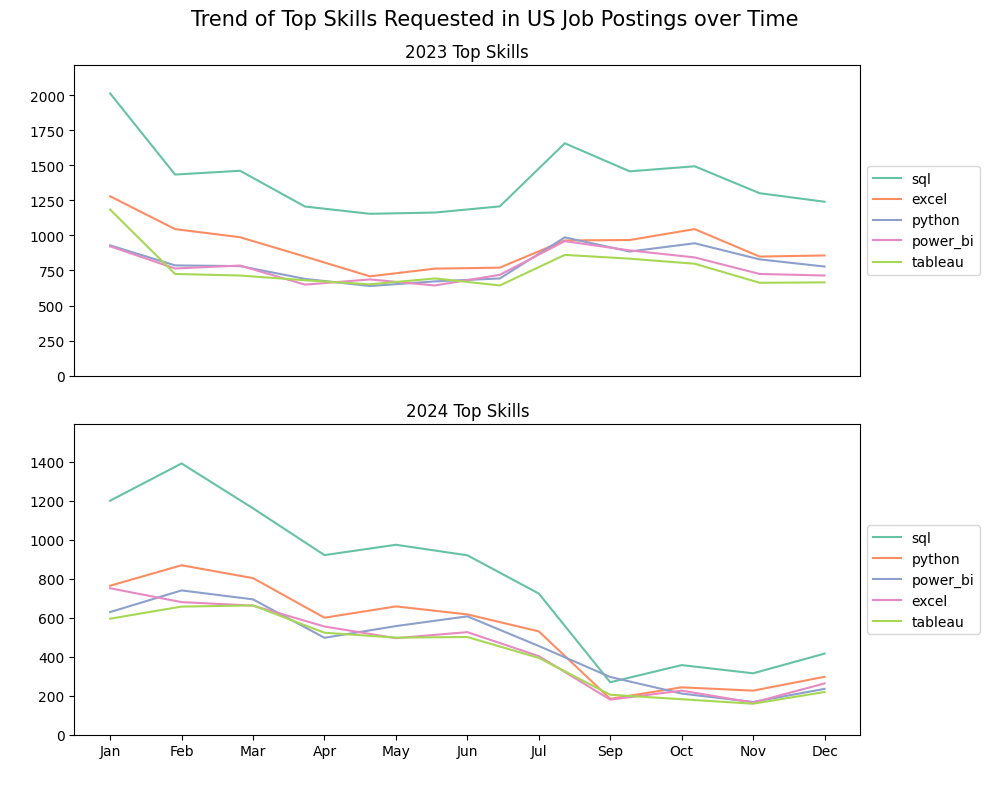

In [ ]:
# Select data
years = [df_DA_2023_top_skills , df_DA_2024_top_skills]

# Set Titles
titles = ['2023 Top Skills' , '2024 Top Skills']

fig , ax = plt.subplots(2 , 1 , figsize = (10,8))

for i , df_year in enumerate(years):
    sns.lineplot(data = df_year , dashes = False , legend = 'full', palette = 'Set2' , ax = ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(" ")
    ax[i].set_ylabel(" ")
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set_ylim(0,df_year.max().max() + 200)   # set ylim from 0 to the max number in df

    if i != len(years) - 1:
        ax[i].set_xticks([])    # Set xticks for the last visual in plot
    
fig.suptitle('Trend of Top Skills Requested in US Job Postings over Time', fontsize=15)
fig.tight_layout(h_pad=0.5) 
plt.show()